# ATMO 5322, Spring 2026
## Homework 1, due 1 Feb by 11:59 pm.

The purpose of this homework assignement is to test your computational setup, and experiment with a basic thunderstorm charge structure. In the process, you will gain experience navigating a 3D computational grid and pulling out cross section slices.

This assignment uses the [FiPy package from NIST](https://pages.nist.gov/fipy/en/latest/index.html) to solve the electrostatic Poisson problem. It is a generic partial differential equation solver, so you can use it for many other problems, such as solving for the nonlinear perturbation pressure gradient force in severe storm dynamics.

There are three homework questions listed at the bottom of this notebook. As you work, push as many changes to Github as you want. I'll use whatever changes you have pushed at the deadline!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from fipy import Grid3D, CellVariable, DiffusionTerm
from fipy.tools.numerix import sqrtDot, reshape
import numpy as np

# Set up a 3D grid, using the engineer's coordinate convention
# x coordinate is left/right
# y coordinate is bottom/top
# z coordinate is front/back
Lx = 100.0e3/2
Ly = 100.0e3/2 # meters
Lz = 20.0e3 # approximate height of electrosphere is 65 km, Fig 1.11 MR98
dx = 2.0e3
dy = 2.0e3
dz = 1.0e3

# Horizontal coordinates of the grid center 
Xc, Yc = Lx/2.0, Ly/2.0

# Use image charges?
mirror=False

phiGround = 0. # potential of ground
phiElectrosphere = 300.0e3 # potential of electrosphere, V

print("Value of background electric field is {0} V/m".format((phiElectrosphere-phiGround)/Ly))

mesh = Grid3D(dx=dx, dy=dy, dz=dz, Lx=Lx, Ly=Ly, Lz=Lz )
X, Y, Z = mesh.cellCenters
print(X.shape, Y.shape, Z.shape, type(X))

Value of background electric field is 6.0 V/m
(12500,) (12500,) (12500,) <class 'numpy.ndarray'>


In [3]:
phi = CellVariable(name = "Potential (V)",
                    mesh = mesh,
                    value = phiGround)
rho = CellVariable(name = "Charge density (C m$^{-3}$)", mesh = mesh)

# Set up the Poisson problem
permittivity = 8.854e-12 # vacuum, F/m
phi.equation = (DiffusionTerm(coeff = permittivity) + rho == 0)

# there is also grad, which is first order. facegrad is second order.
# Efield = -phi.faceGrad
# Finally, we can use leastSquaresGrad, which is calculated at the cell centers.
# This is a bit harder to imagine from the point of view of a discretized gradient calculation
# but has the advantage that we can slice the arrays the same way as the scalar variables.
Efield = -phi.leastSquaresGrad
Efield.name = 'Electric Field (V/m)'

# Only need these for faceGrad.
EfaceX, EfaceY, EfaceZ = Efield.mesh.faceCenters
print(EfaceX.shape)

(39125,)


In [4]:
# Zero E field (gradient of potential) on exterior
phi.faceGrad.constrain(0 * mesh.faceNormals, where=mesh.exteriorFaces)

# Zero potential at ground, overwrites previous condition on bottom boundary
phi.constrain(phiGround, mesh.facesFront)

# Potential provided by ionosphere, approximated as a single upper boundary, i.e., the electrosphere
phi.constrain(phiElectrosphere, mesh.facesBack)
    
print(X.shape, mesh.shape, phi.shape)


(12500,) (25, 25, 20) (12500,)


In [5]:
def cylinder_at(rho, rho0, X0, Y0, Z0, depth, radius):
    """ X0, Y0, Z0: Center of cylinder
    rho: whole-domain charge density variable
    rho: charge density to assign at cylinder
    depth: thickness in Z, i.e., Z0-depth/2, Z0+depth/2
    radius: cylinder radius
    """
    
    X, Y, Z = rho.mesh.cellCenters
    
    dX = X-X0
    dY = Y-Y0
    dZ = Z-Z0
    
    charged = (
        (np.sqrt(dX*dX + dY*dY) <= radius) &
        (np.abs(dZ) <= (depth/2.0))
    )
    print("Charging {0} grid boxes".format(charged.sum()))
    
    # Note the warning at https://www.ctcms.nist.gov/fipy/documentation/USAGE.html
    # Since rho does not change during the solve for phi, we can use the constraint
    # mechanism.
    # rho.constrain(rho0, charged)
    rho.setValue(rho0, where=charged)

In [6]:
rho0 = 0.5e-9

cylinder_at(rho, rho0/2.0, Xc, Yc, 3.0e3, 1.2e3, 4.0e3)
cylinder_at(rho, -rho0*1.5, Xc, Yc, 7.0e3, 1.2e3, 8.0e3)
cylinder_at(rho, rho0*1.5, Xc, Yc, 10.5e3, 1.2e3, 10.0e3)


Charging 26 grid boxes
Charging 98 grid boxes
Charging 81 grid boxes


In [7]:
import matplotlib
# matplotlib.use('WebAgg')
import matplotlib.pyplot as plt

red_blue = plt.get_cmap('RdBu_r')
helix = plt.get_cmap('cubehelix_r')

In [8]:
# reversed shape based on FiPy's matplotlib2DGridViewer source
mesh_shape = mesh.shape[::-1]
plotx, ploty, plotz = np.reshape(X, mesh_shape), np.reshape(Y, mesh_shape), np.reshape(Z, mesh_shape)
plotrho = np.reshape(rho.value, mesh_shape)

In [9]:
# Find the index along the X and Y dimensions 
# It's a cartesian grid. We have taken the min along the axis we know is repeated across
# the other two dimensions, so the value should be the same across the other two axes, 
# allowing us to select [0,0] or any other index value.
Xci = np.argmin(np.abs(plotx-Xc), axis=-1)[0,0]
Yci = np.argmin(np.abs(ploty-Yc), axis=-2)[0,0]

# Set up the slice location
YZslice = slice(None), slice(None), Xci
XZslice = slice(None), Yci, slice(None)

# Plot the charge configuration along the slice above

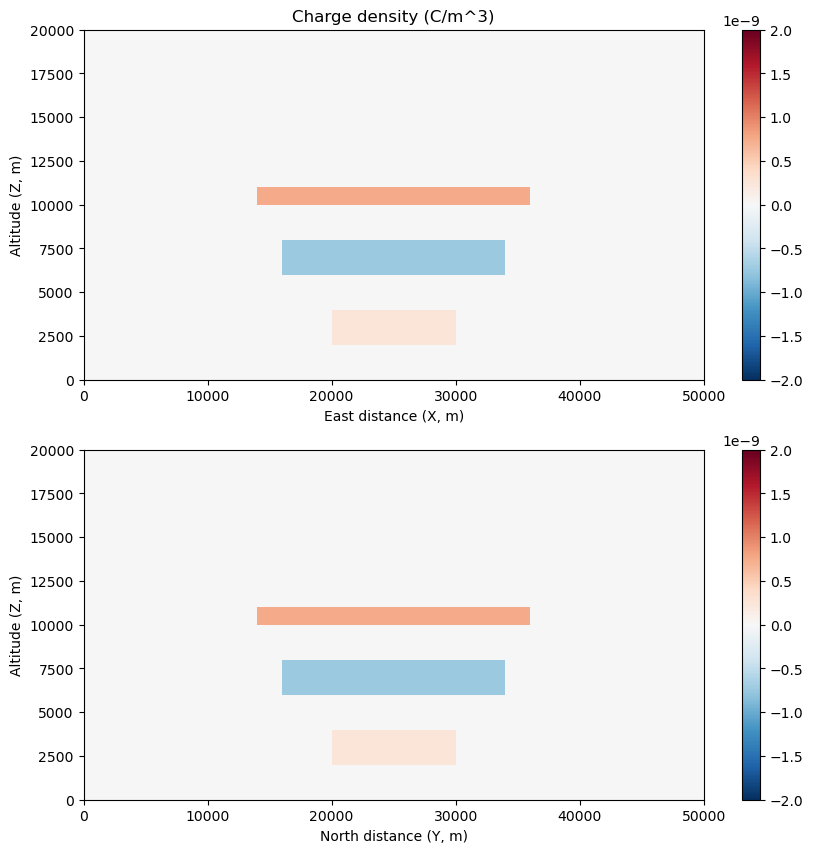

In [10]:
f, axs = plt.subplots(2,1,figsize=(10,10))
ax_rho_EW = axs[0]
ax_rho_NS = axs[1]

rhonorm = matplotlib.colors.Normalize(vmin=-2e-9, vmax=2e-9)

# Select center along Y to plot Z vs. X
rho_plot_EW = ax_rho_EW.pcolormesh(plotx[XZslice], plotz[XZslice], plotrho[XZslice], cmap=red_blue, norm=rhonorm)
ax_rho_EW.set_xlabel("East distance (X, m)")
ax_rho_EW.set_ylabel("Altitude (Z, m)")
ax_rho_EW.set_title("Charge density (C/m^3)")
plt.colorbar(rho_plot_EW, ax=ax_rho_EW)
rho_plot_NS = ax_rho_NS.pcolormesh(ploty[YZslice], plotz[YZslice], plotrho[YZslice], cmap=red_blue, norm=rhonorm)
ax_rho_NS.set_xlabel("North distance (Y, m)")
ax_rho_NS.set_ylabel("Altitude (Z, m)")
plt.colorbar(rho_plot_NS, ax=ax_rho_NS)

# Solve
(computationally expensive)

In [11]:
phi.equation.solve(var=phi)

# Plot solution

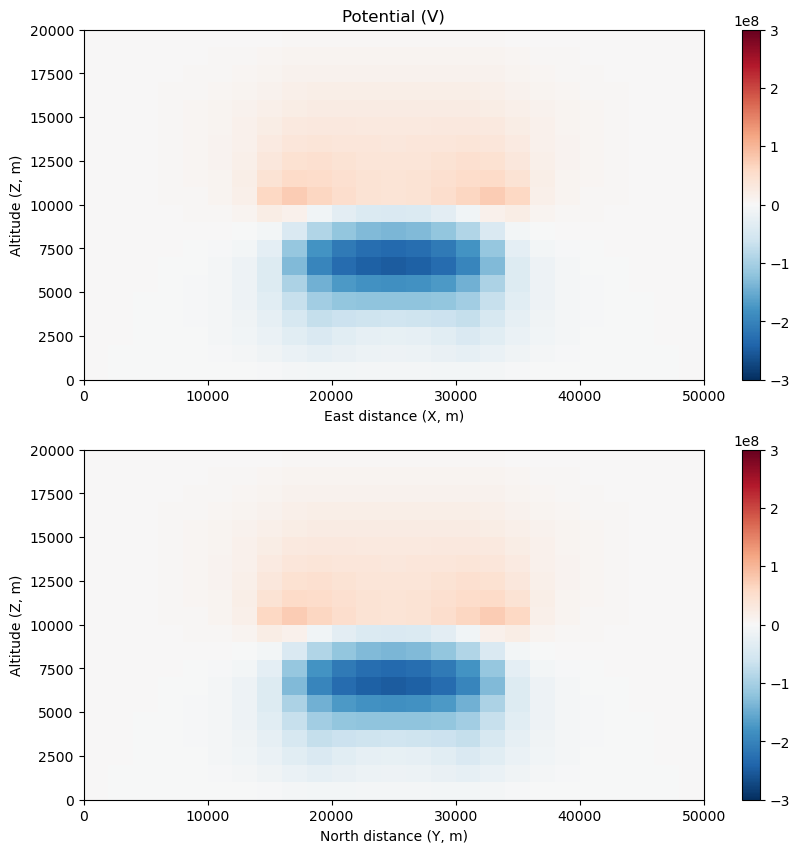

In [12]:
f, axs = plt.subplots(2,1,figsize=(10,10))
ax_phi_EW = axs[0]
ax_phi_NS = axs[1]

phimax = 3e8

plotphi = np.reshape(phi.value, mesh_shape)
phinorm = matplotlib.colors.Normalize(vmin=-phimax, vmax=phimax)

# Select center along Y to plot Z vs. X
phi_plot_EW = ax_phi_EW.pcolormesh(plotx[XZslice], plotz[XZslice], plotphi[XZslice], cmap=red_blue, norm=phinorm)
ax_phi_EW.set_xlabel("East distance (X, m)")
ax_phi_EW.set_ylabel("Altitude (Z, m)")
ax_phi_EW.set_title("Potential (V)")
plt.colorbar(phi_plot_EW, ax=ax_phi_EW)
phi_plot_NS = ax_phi_NS.pcolormesh(ploty[YZslice], plotz[YZslice], plotphi[YZslice], cmap=red_blue, norm=phinorm)
ax_phi_NS.set_xlabel("North distance (Y, m)")
ax_phi_NS.set_ylabel("Altitude (Z, m)")
plt.colorbar(phi_plot_NS, ax=ax_phi_NS)

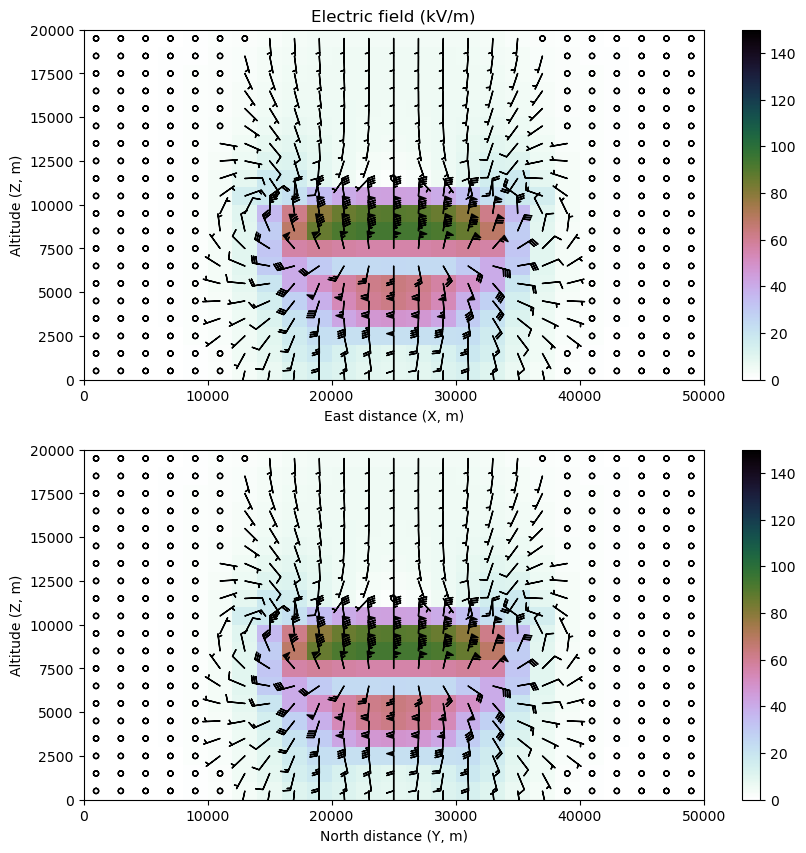

In [13]:
f, axs = plt.subplots(2,1,figsize=(10,10))
ax_field_EW = axs[0]
ax_field_NS = axs[1]

Emax = 150
fraction = 1.0
fieldnorm = matplotlib.colors.Normalize(vmin=0, vmax=Emax)


Emagplot = np.reshape(Efield.mag.value*1e-3, mesh_shape)
Explot = np.reshape(Efield[0, :].value*1e-3, mesh_shape)
Eyplot = np.reshape(Efield[1, :].value*1e-3, mesh_shape)
Ezplot = np.reshape(Efield[2, :].value*1e-3, mesh_shape)


# Select center along Y to plot Z vs. X
field_plot_EW = ax_field_EW.pcolormesh(plotx[XZslice], plotz[XZslice], Emagplot[XZslice], cmap=helix, norm=fieldnorm)
subset = ((np.random.rand(*Emagplot[XZslice].shape) < fraction) &
          (Emagplot[XZslice] < Emax)
         )
field_barb_EW = ax_field_EW.barbs(plotx[XZslice][subset], plotz[XZslice][subset],
                                  Explot[XZslice][subset], Ezplot[XZslice][subset], 
                                  color='k', length=5)
ax_field_EW.set_xlabel("East distance (X, m)")
ax_field_EW.set_ylabel("Altitude (Z, m)")
ax_field_EW.set_title("Electric field (kV/m)")
plt.colorbar(field_plot_EW, ax=ax_field_EW)

field_plot_NS = ax_field_NS.pcolormesh(ploty[YZslice], plotz[YZslice], Emagplot[YZslice], cmap=helix, norm=fieldnorm)
subset = ((np.random.rand(*Emagplot[YZslice].shape) < fraction) &
          (Emagplot[YZslice] < Emax)
         )
field_barb_NS = ax_field_NS.barbs(ploty[YZslice][subset], plotz[YZslice][subset],
                                  Eyplot[YZslice][subset], Ezplot[YZslice][subset], 
                                  color='k', length=5)
ax_field_NS.set_xlabel("North distance (Y, m)")
ax_field_NS.set_ylabel("Altitude (Z, m)")
plt.colorbar(field_plot_NS, ax=ax_field_NS)

# Homework questions

Make a separate set of plots (for charge, potential, E) for each of the these questions.

1. Add a negative charge cylinder of density 0.05 nC m$^{-3}$ from 13 to 14 km, of the same diameter as the upper positive charge. What are the main changes to **E** in the domain?

2. Building on the setup from (1), make the lower positive charge density equal to that of the main negative charge. What are the main changes to potential and **E** in the domain?
   
3. Building on the setup from (2), move the north-alitude slice to just touch the last grid boxes of the cylinder of positive charge, and add a red line visualizing where the slices are taken on the plots. What are the main changes to E in the north-altitude slice?
